In [1]:
from pylab import *
import pandas as pd
from timeit import default_timer as timer
from ImageAlgoKD import *
from tqdm import tqdm

In [2]:
Points = np.fromfile("../../data/MNIST/MNIST_train_data.dat").reshape(-1,785)
Points = Points[:,0:-1]
#Points = Points[:1000]
nPoints,kPoints = Points.shape
wPoints = np.ones(nPoints)

In [3]:
Points  = Points .astype(np.float32)
wPoints = wPoints.astype(np.float32)
nPoints = np.int32(nPoints)
kPoints = np.int32(kPoints)

rho     = np.zeros(nPoints).astype(np.float32)
rhorank = np.zeros(nPoints).astype(np.int32)
nh      = np.zeros(nPoints).astype(np.int32)
nhd     = np.zeros(nPoints).astype(np.float32)

In [4]:
MAXDISTANCE        = 1.5
KERNAL_R           = 0.7
KERNAL_R_NORM      = 0.5
DECISION_RHO_KAPPA = 4
DECISION_NHD       = 0.7
CONTINUITY_NHD     = KERNAL_R

# 1. Find rho and NearestHigher

In [ ]:
start = timer()

d_Points  = cuda.mem_alloc(Points.nbytes)
d_wPoints = cuda.mem_alloc(wPoints.nbytes)

d_rho     = cuda.mem_alloc(rho.nbytes)
d_rhorank = cuda.mem_alloc(rhorank.nbytes)
d_nh      = cuda.mem_alloc(nh.nbytes)
d_nhd     = cuda.mem_alloc(nhd.nbytes)


cuda.memcpy_htod( d_Points , Points )
cuda.memcpy_htod( d_wPoints, wPoints )
NRUN =100
for run in tqdm(range(NRUN)):
    rho_cuda(d_rho, d_Points, d_wPoints,
         nPoints, kPoints, np.float32(KERNAL_R), np.float32(KERNAL_R_NORM),
         grid=(int(nPoints/1024)+1,1,1),block=(int(1024),1,1))

    rhoranknh_cuda(d_rhorank, d_nh,d_nhd, d_Points, d_rho,
               nPoints, kPoints, np.float32(MAXDISTANCE),
               grid=(int(nPoints/1024)+1,1,1),block=(int(1024),1,1))
    cuda.memcpy_dtoh(rho,d_rho)
    cuda.memcpy_dtoh(rhorank,d_rhorank)
    cuda.memcpy_dtoh(nh,d_nh)
    cuda.memcpy_dtoh(nhd,d_nhd)




end = timer()
print("number of rechits: {}".format(nPoints))
print("time: {:3.6} s".format( (end - start) ))

d_Points.free()
d_wPoints.free()

d_rho.free()
d_rhorank.free()
d_nh.free()
d_nhd.free()

  0%|          | 0/100 [00:00<?, ?it/s]

# 2. Asign Clusters

In [6]:
cluster = -np.ones(nPoints,int)
DECISION_RHO = rho.max()/DECISION_RHO_KAPPA

# 2.1 convert rhorank to argsortrho 0(N)
argsortrho = np.zeros(nPoints,int)
argsortrho[rhorank] = np.arange(nPoints)

# 2.2 find seeds
selectseed = (rho>DECISION_RHO) & (nhd>DECISION_NHD)
seedrho = rho[selectseed]
temp = seedrho.argsort()[::-1]
seedid = np.empty(len(seedrho), int)
seedid[temp] = np.arange(len(seedrho))
cluster[selectseed] = seedid

# 2.3 asign clusters to seeds
for ith in range(nPoints):
    i = argsortrho[ith]
    if  (cluster[i]<0) & (nhd[i]<CONTINUITY_NHD):
        cluster[i] = cluster[nh[i]]

In [7]:
result = pd.DataFrame()
result['rho'] = pd.Series(rho)
result['rhorank'] = pd.Series(rhorank)
result['nh'] = pd.Series(nh)
result['nhd'] = pd.Series(nhd)
result['cluster'] = pd.Series(cluster)

# Make Plots

In [8]:
%matplotlib inline
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

Text(0.5,1,'Decision Plot')

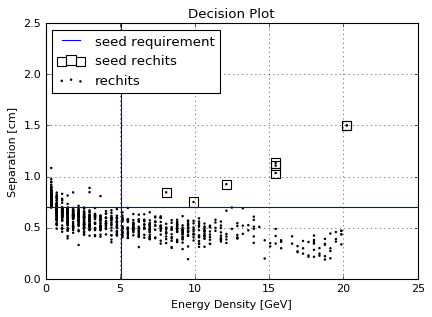

In [9]:
plt.scatter(result.rho[selectseed],result.nhd[selectseed],marker='s',
            s=70,edgecolor="k",color="None",label="seed rechits")
plt.scatter(result.rho, result.nhd, marker='.',edgecolor="None",color="k",label="rechits")
plt.axvline(DECISION_RHO,color="b",label="seed requirement")
plt.axhline(DECISION_NHD,color="b")

plt.xlabel("Energy Density [GeV]")
plt.ylabel("Separation [cm]")
plt.legend(loc="upper left",fontsize=12)
plt.xlim(-0)
plt.ylim(0,2.5)
plt.grid(True)
plt.title("Decision Plot",fontsize=12)

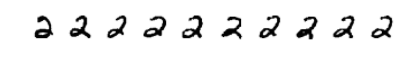

In [18]:
cl = Points[cluster==7]
for i in range(10):
    plt.subplot(1,10,i+1)
    img = cl[i].reshape(28,28).T
    plt.imshow(img,cmap="Greys")
    plt.axis('off')